# Learning TensorFlow: Using Convolutions with Complex Images

## Overview

The previous labs in this quest illustrate how an image classifier can be trained on simple datasets like Fashion MNIST. Fashion MNIST dataset has images of size 28x28, where the subject is centered. In this lab you'll go further and learn how an image classifier can be trained to recognize features in an image where the subject can be anywhere in the image!
You'll train a classifier that identifies if the given image contains a horse or a human. The network will be trained to recognize features that help to determine which is which.

This tutorial demonstrates 
how to 

1.   Train a CNN model on Vertex AI using the SDK for Python
2.   Deploy a custom image classification model for online prediction using Vertex AI

### Dataset

You will train a neural network to classify images from a dataset called [Horses or Humans](https://www.tensorflow.org/datasets/catalog/horses_or_humans).

This dataset contains a large number of images of horses and humans. It has 1283 images of resolution of 300x300, as seen here:

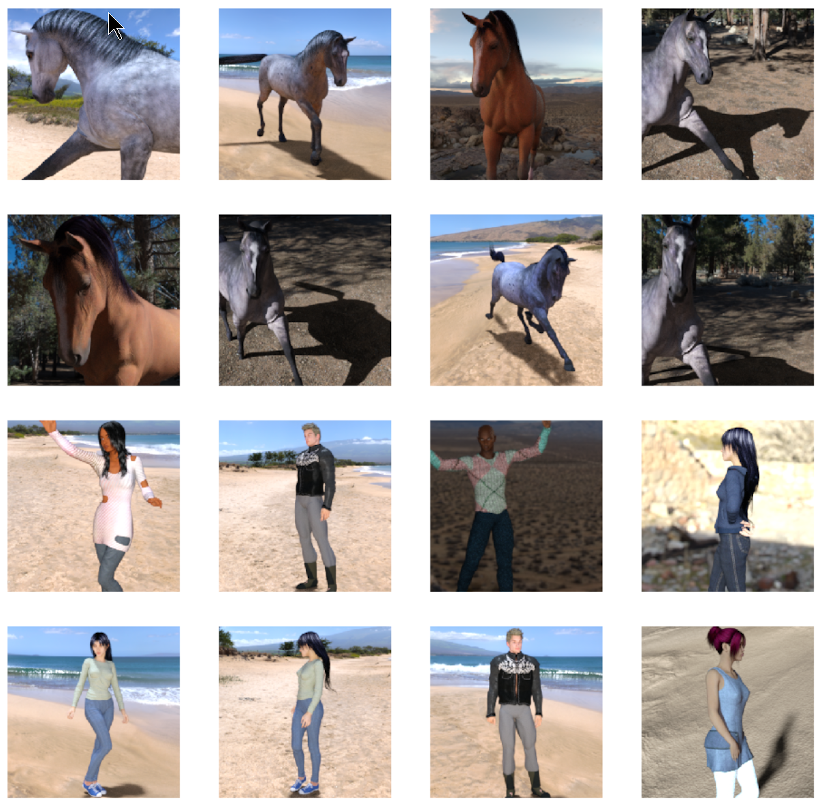

In this notebook, you will use 1027 images to train the network and 256 images to evaluate how accurately the network learned to classify the images.

### Objective

In this notebook, you will create a custom-trained CNN model from a Python script in a Docker container using the Vertex SDK for Python, and then do a prediction on the deployed model by sending data. Alternatively, you can create custom-trained models using `gcloud` command-line tool, or online using the Cloud Console.

The steps performed include:

- Create a Vertex AI custom job and train a CNN model.
- Deploy the `Model` resource to a serving `Endpoint` resource.
- Make a prediction.
- Undeploy the `Model` resource.

### Costs

This tutorial uses billable components of Google Cloud (GCP):

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Setting up the environment

### Installation

**Note:** Disregard the errors and warnings associated with the installation.

In [1]:
!pip install --user google-cloud-aiplatform 
!pip install --user tensorflow-text 
!pip install --user tensorflow-datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 44.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 79.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 77.4 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you p

In [2]:
!pip install --user protobuf==3.20.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 3.20.1 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 3.20.1 which is incompatible.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-aiplatform 1.75.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.20.1 which is incompatible.
google-cloud-artifact-registry 1.14.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!

### Restart the kernel

Once you've installed everything, you need to restart the notebook kernel so it can find the packages.

In [3]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

In [1]:
PROJECT_ID = ! gcloud config get project
PROJECT_ID = PROJECT_ID[0]

import subprocess

# Execute the gcloud command to get the region
output = subprocess.check_output(["gcloud", "config", "get-value", "compute/region"])

# Decode the output from bytes to string
region = output.decode("utf-8").strip()


LOCATION = region

print(PROJECT_ID)
print(LOCATION)

qwiklabs-gcp-01-dc42083283ed
us-east1


#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`. 

In [2]:
import os

PROJECT_ID = "PROJECT_ID"

if not os.getenv("IS_TESTING"):
    # Get your Google Cloud project ID from gcloud
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  qwiklabs-gcp-01-dc42083283ed


#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [3]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. Vertex AI runs
the code from this package. In this tutorial, Vertex AI also saves the
trained model that results from your job in the same bucket. Using this model artifact, you can then
create Vertex AI model and endpoint resources in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [23]:
BUCKET_NAME = f"gs://{PROJECT_ID}"
REGION = f"{LOCATION}"  # @param {type:"string"}

In [24]:
PROJECT_ID

'qwiklabs-gcp-01-dc42083283ed'

In [25]:
REGION

'us-east1'

In [26]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == f"gs://{PROJECT_ID}":
    BUCKET_NAME = "gs://" + PROJECT_ID

**Only if your bucket doesn't already exist**: Run the following cells to create your Cloud Storage bucket.

In [27]:
BUCKET_NAME

'gs://qwiklabs-gcp-01-dc42083283ed'

In [28]:
! gsutil mb -l $REGION $BUCKET_NAME

Creating gs://qwiklabs-gcp-01-dc42083283ed/...


#### Check progress
Go back to lab manual and Click _Check my progress_ under **Create a Cloud Storage Bucket** section to verify that the bucket is created.

### Set up variables

Next, set up some variables used throughout the tutorial.

#### Import Vertex SDK for Python

Import the Vertex SDK for Python into your Python environment and initialize it.

In [29]:
import os
import sys

from google.cloud import aiplatform
from google.cloud.aiplatform import gapic as aip

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

#### Set hardware accelerators

Here to run a container image on a CPU, we set the variables `TRAIN_GPU/TRAIN_NGPU` and `DEPLOY_GPU/DEPLOY_NGPU` to `(None, None)` since this notebook is meant to be run in a Qwiklab environment where GPUs cannot be provisioned. 
  
Note: If you happen to be running this notebook from your personal GCP account, set the variables `TRAIN_GPU/TRAIN_NGPU` and `DEPLOY_GPU/DEPLOY_NGPU` to use a container image supporting a GPU and the number of GPUs allocated to the virtual machine (VM) instance. For example, to use a GPU container image with 4 Nvidia Tesla K80 GPUs allocated to each VM, you would specify:

    (aip.AcceleratorType.NVIDIA_TESLA_K80, 4)

See the [locations where accelerators are available](https://cloud.google.com/vertex-ai/docs/general/locations#accelerators).

In [30]:
TRAIN_GPU, TRAIN_NGPU = (None, None)
DEPLOY_GPU, DEPLOY_NGPU = (None, None)

#### Set pre-built containers

There are two ways you can train a custom model using a container image:

- **Use a Google Cloud prebuilt container**. If you use a prebuilt container, you will additionally specify a Python package to install into the container image. This Python package contains your code for training a custom model.

- **Use your own custom container image**. If you use your own container, the container needs to contain your code for training a custom model.


Here you will use pre-built containers provided by Vertex AI to run training and prediction.

For the latest list, see [Pre-built containers for training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) and [Pre-built containers for prediction](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)

In [31]:
TRAIN_VERSION = "tf-cpu.2-8"
DEPLOY_VERSION = "tf2-cpu.2-8"

TRAIN_IMAGE = "us-docker.pkg.dev/vertex-ai/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(DEPLOY_VERSION)

print("Training:", TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

Training: us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-8:latest None None
Deployment: us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest None None


#### Set machine types

Next, set the machine types to use for training and prediction.

- Set the variables `TRAIN_COMPUTE` and `DEPLOY_COMPUTE` to configure your compute resources for training and prediction.
 - `machine type`
     - `e2-standard`: 4 GB of memory per vCPU
     - `e2-highmem`: 8 GB of memory per vCPU
     - `e2-highcpu`: 1 GB of memory per vCPU
 - `vCPUs`: number of \[2, 4, 8, 16, 32, 64, 96 \]

*Note: The following is not supported for training:*

 - `standard`: 2 vCPUs
 - `highcpu`: 2, 4 and 8 vCPUs

*Note: You may also use n2 and e2 machine types for training and deployment, but they do not support GPUs*.

In [32]:
MACHINE_TYPE = "e2-standard"

VCPU = "4"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

MACHINE_TYPE = "e2-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

Train machine type e2-standard-4
Deploy machine type e2-standard-4


## Design and Train the Convolutional Neural Network

Now you are ready to design and train your own custom-trained CNN model with Horses or Humans data.  


### Training script

In the next cell, you will write the contents of the training script, `task.py`. In summary:

- Get the directory where to save the model artifacts from the environment variable `AIP_MODEL_DIR`. This variable is set by the training service.
- Loads Horses or Humans dataset from TF Datasets (tfds).
- Builds a CNN model using tf.keras model API. (Please see code comments for 
details about the layers in the CNN).
- Compiles the model (`compile()`).
- Trains the model (`fit()`) with epochs.
- Saves the trained model (`save(MODEL_DIR)`) to the specified model directory.

In [33]:
%%writefile task.py
# Training Horses vs Humans using CNN

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.python.client import device_lib
import argparse
import os
import sys
tfds.disable_progress_bar()

parser = argparse.ArgumentParser()

parser.add_argument('--epochs', dest='epochs',
                    default=10, type=int,
                    help='Number of epochs.')

args = parser.parse_args()

print('Python Version = {}'.format(sys.version))
print('TensorFlow Version = {}'.format(tf.__version__))
print('TF_CONFIG = {}'.format(os.environ.get('TF_CONFIG', 'Not found')))
print('DEVICES', device_lib.list_local_devices())

# Define batch size
BATCH_SIZE = 32

# Load the dataset
datasets, info = tfds.load('horses_or_humans', with_info=True, as_supervised=True)

# Normalize and batch process the dataset
ds_train = datasets['train'].map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y)).batch(BATCH_SIZE)


# Build the Convolutional Neural Network
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(),
      loss = tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy()])



# Train and save the model
MODEL_DIR = os.getenv("AIP_MODEL_DIR")

model.fit(ds_train, epochs=args.epochs)
model.save(MODEL_DIR)

Writing task.py


### Define the command args for the training script

Prepare the command-line arguments to pass to your training script.
- `args`: The command line arguments to pass to the corresponding Python module. In this example, they will be:
  - `"--epochs=" + EPOCHS`: The number of epochs for training.

In [34]:
JOB_NAME = "custom_job_" + TIMESTAMP
MODEL_DIR = "{}/{}".format(BUCKET_NAME, JOB_NAME)

EPOCHS = 8

CMDARGS = [
    "--epochs=" + str(EPOCHS),
]

### Train the model

Define your custom training job on Vertex AI.

Use the `CustomTrainingJob` class to define the job, which takes the following parameters:

- `display_name`: The user-defined name of this training pipeline.
- `script_path`: The local path to the training script.
- `container_uri`: The URI of the training container image.
- `requirements`: The list of Python package dependencies of the script.
- `model_serving_container_image_uri`: The URI of a container that can serve predictions for your model — either a prebuilt container or a custom container.

Use the `run` function to start training, which takes the following parameters:

- `args`: The command line arguments to be passed to the Python script.
- `replica_count`: The number of worker replicas.
- `model_display_name`: The display name of the `Model` if the script produces a managed `Model`.
- `machine_type`: The type of machine to use for training.
- `accelerator_type`: The hardware accelerator type.
- `accelerator_count`: The number of accelerators to attach to a worker replica.

The `run` function creates a training pipeline that trains and creates a `Model` object. After the training pipeline completes, the `run` function returns the `Model` object.

You can read more about the `CustomTrainingJob.run` API [here](https://googleapis.dev/python/aiplatform/latest/aiplatform.html?highlight=customtraining#google.cloud.aiplatform.CustomTrainingJob.run)

In [35]:
job = aiplatform.CustomTrainingJob(
    display_name=JOB_NAME,
    script_path="task.py",
    container_uri=TRAIN_IMAGE,
    requirements=["tensorflow_datasets==4.6.0"],
    model_serving_container_image_uri=DEPLOY_IMAGE,
)

MODEL_DISPLAY_NAME = "horsesvshumans-" + TIMESTAMP

# Start the training
if TRAIN_GPU:
    model = job.run(
        model_display_name=MODEL_DISPLAY_NAME,
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
        accelerator_type=TRAIN_GPU.name,
        accelerator_count=TRAIN_NGPU,
    )
else:
    model = job.run(
        model_display_name=MODEL_DISPLAY_NAME,
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
        accelerator_count=0,
    )

Training script copied to:
gs://qwiklabs-gcp-01-dc42083283ed/aiplatform-2025-01-29-15:24:36.908-aiplatform_custom_trainer_script-0.1.tar.gz.
Training Output directory:
gs://qwiklabs-gcp-01-dc42083283ed/aiplatform-custom-training-2025-01-29-15:24:37.122 
View Training:
https://console.cloud.google.com/ai/platform/locations/us-east1/training/813710760004812800?project=739572437636
CustomTrainingJob projects/739572437636/locations/us-east1/trainingPipelines/813710760004812800 current state:
PipelineState.PIPELINE_STATE_PENDING
CustomTrainingJob projects/739572437636/locations/us-east1/trainingPipelines/813710760004812800 current state:
PipelineState.PIPELINE_STATE_PENDING
CustomTrainingJob projects/739572437636/locations/us-east1/trainingPipelines/813710760004812800 current state:
PipelineState.PIPELINE_STATE_PENDING
CustomTrainingJob projects/739572437636/locations/us-east1/trainingPipelines/813710760004812800 current state:
PipelineState.PIPELINE_STATE_PENDING
CustomTrainingJob projects

The Training pipeline will take an average of **12 to 14** minutes to finish.

To view the training pipeline status, you have to navigate to **Vertex AI** ➞ **Training**  

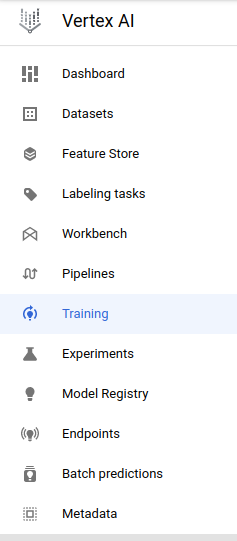

You can see the status of the current training pipeline as seen below

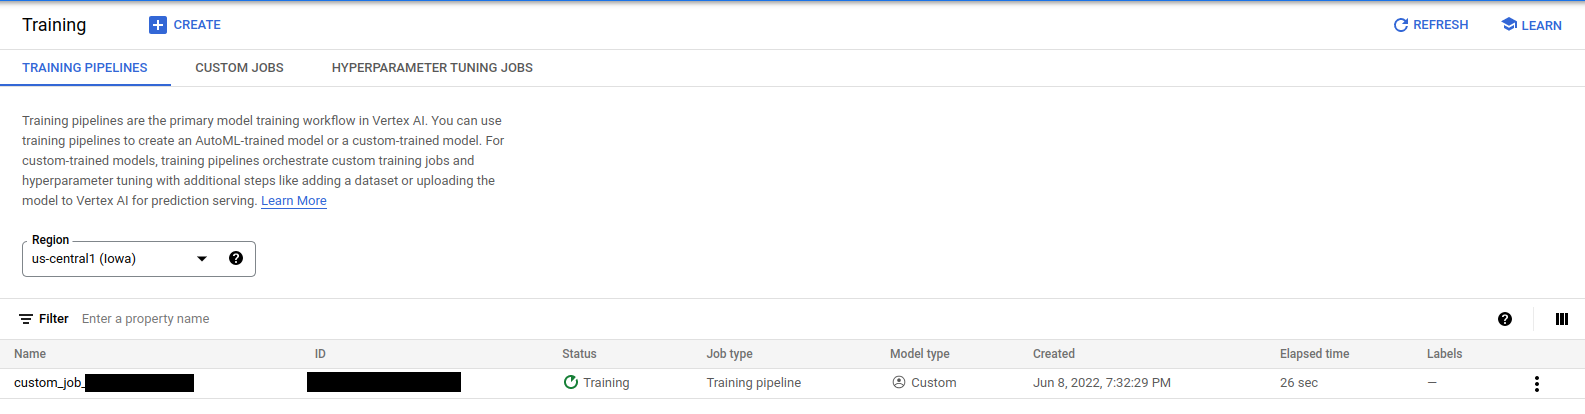

Once the model has been successfully trained, you can see a custom trained model if you head to **Vertex AI** ➞ **Model Registry**

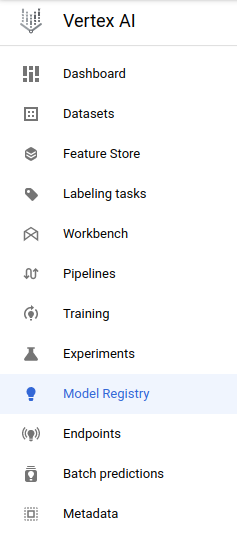

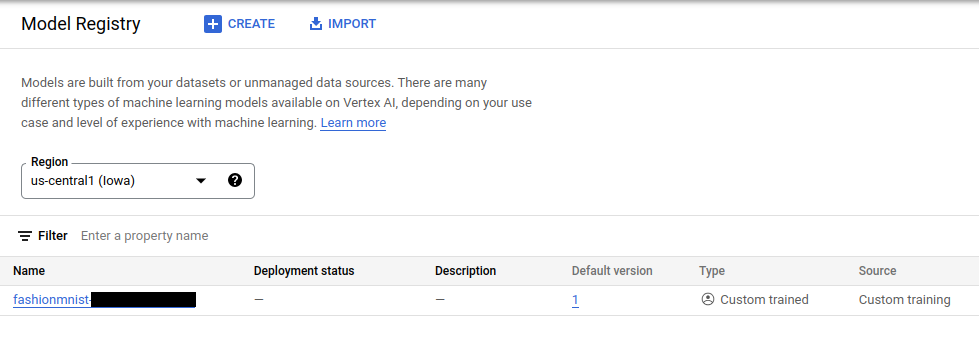

#### Check progress
Go back to lab manual and Click _Check my progress_ under **Train the Model on Vertex AI** section to verify that the pipeline ran successfully.

### Testing

Get the test dataset and load the images/labels.

Set the batch size to -1 to load the entire dataset.

In [36]:
import tensorflow_datasets as tfds
import numpy as np

tfds.disable_progress_bar()

In [37]:
datasets, info = tfds.load('horses_or_humans', batch_size=-1, with_info=True, as_supervised=True)

test_dataset = datasets['test']

2025-01-29 15:55:14.494803: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 15:55:14.856859: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 15:55:15.193561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738166115.456670    8808 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738166115.538240    8808 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 15:55:16.311694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Dataset horses_or_humans downloaded and prepared to /home/jupyter/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


2025-01-29 15:55:26.909138: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-01-29 15:55:27.095630: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-01-29 15:55:31.306158: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 277290000 exceeds 10% of free system memory.


Load the TensorFlow Dataset as NumPy arrays (images, labels)

In [38]:
x_test, y_test = tfds.as_numpy(test_dataset)

# Normalize (rescale) the pixel data by dividing each pixel by 255. 
x_test = x_test.astype('float32') / 255.

Ensure the shapes are correct here

In [39]:
x_test.shape, y_test.shape

((256, 300, 300, 3), (256,))

In [40]:
#@title Pick the number of test images
NUM_TEST_IMAGES = 20 #@param {type:"slider", min:1, max:20, step:1}
x_test, y_test = x_test[:NUM_TEST_IMAGES], y_test[:NUM_TEST_IMAGES]

In [41]:
# Convert to python list
list_x_test = x_test.tolist()

## Batch prediction request

Since the test data is large, you will send a batch prediction request to your deployed model instead of an online prediction. While starting a batch prediction job you will specify a cloud storage bucket and the output of the batch prediction will be saved in that bucket.

#### Precomputed batch prediction files

Batch prediction requests will take 25 to 30 mins to finish computing on Vertex AI. For ease, we ran batch prediction on this model and saved its prediction files in a public GCS bucket(gs://spls). You will use these files for prediction. After finishing this section you can run the Batch prediction request and check it for yourselves.

#### Retrieve batch prediction results from public gcs bucket
You'll now retrieve the predictions and store them in a list. The predictions will be in a JSONL format, which you indicate when you create the batch prediction job. The predictions are located in a subdirectory starting with the name prediction. Within that directory, there is a file named prediction.results-xxxx-of-xxxx.

The following code displays the contents. You will get a row for each prediction.

In [42]:
import json

PUBLIC_BUCKET_NAME = 'gs://spls'
PUBLIC_DESTINATION_FOLDER = 'gsp634'

RESULTS_DIRECTORY = "prediction_results"

# Create destination directory for downloaded results.
os.makedirs(RESULTS_DIRECTORY, exist_ok=True)

BATCH_PREDICTION_GCS_DEST_PREFIX = PUBLIC_BUCKET_NAME + "/" + PUBLIC_DESTINATION_FOLDER

# Download the results.
! gsutil -m cp -r $BATCH_PREDICTION_GCS_DEST_PREFIX $RESULTS_DIRECTORY

# Store the downloaded prediction file paths into a list
results_files = []
for dirpath, subdirs, files in os.walk(RESULTS_DIRECTORY):
    for file in files:
        if file.startswith("prediction.results"):
            results_files.append(os.path.join(dirpath, file))

            
def consolidate_results():          
    # Consolidate all the results into a list
    results = []
    for results_file in results_files:
        # Download each result
        with open(results_file, "r") as file:
            results.extend([json.loads(line) for line in file.readlines()])
    return results

results = consolidate_results()

Copying gs://spls/gsp634/prediction.results-00001-of-00003...
Copying gs://spls/gsp634/prediction.results-00000-of-00003...                   
Copying gs://spls/gsp634/prediction.results-00002-of-00003...


#### Check progress
Go back to lab manual and Click _Check my progress_ under **Copy the Batch Prediction Results** section to verify that the deployment was a success.

### Rearrange the Batch prediction result
Batch prediction results are always delivered in random order. So we will compare the result with the original `x_test` value and rearrange the results according to that. This is necessary for evaluating the results.

In [43]:
def rearrange_results():
    # Empty array to hold the new ordered result
    new_results = [None]*20

    for result in results:
        instance_img = np.array(result["instance"])
        for i in range(len(x_test)):
            # If the result image and x_test image matches,
            # then get the index of the image in x_test.
            # Insert the result into that index
            # in the new_results array
            if (instance_img == x_test[i]).all():
                new_results[i] = result
    return new_results
                
new_results = rearrange_results()

### Evaluate results

You can then run a quick evaluation on the prediction results:

1. Compare the predicted labels to the actual labels
2. Calculate `accuracy` as `correct/total`

In [44]:
def evaluate_results():
    # If the prediction value of result is less than 0.5 then it means model predicted this image to belong to class 0, i.e, horse,
    # else the model predicted the image to belong to class 1, i.e, human.
    y_predicted = [0 if result["prediction"][0] <= 0.5 else 1  for result in new_results]

    correct_ = sum(y_predicted == y_test)
    accuracy = len(y_predicted)
    print(
        f"Correct predictions = {correct_}, Total predictions = {accuracy}, Accuracy = {correct_/accuracy}"
    )
    return y_predicted
    
y_predicted = evaluate_results()

Correct predictions = 19, Total predictions = 20, Accuracy = 0.95


### Plot the result

Here you will plot each image with its predicted label as the title.

If you go through the images, you can see the ones that were wrongly predicted by the model.

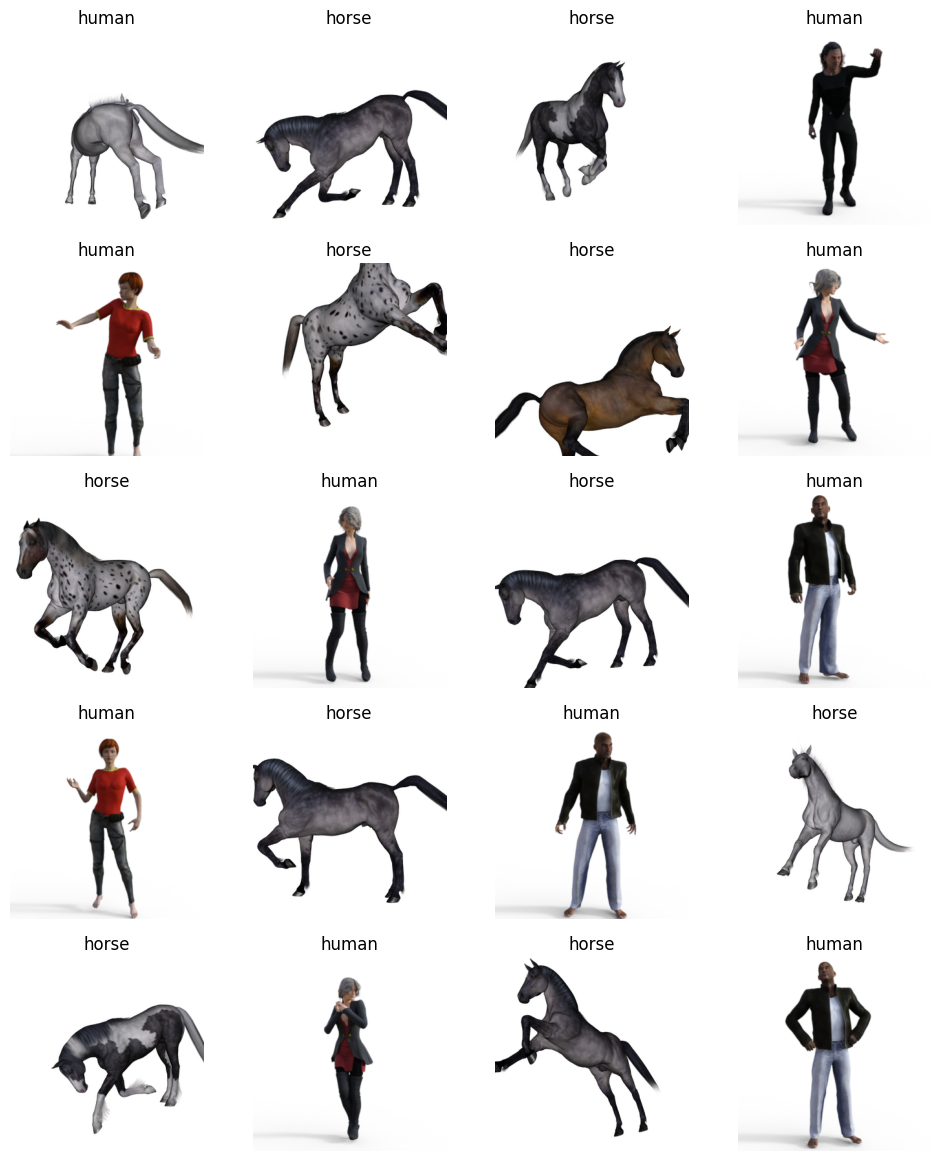

In [45]:
import matplotlib.pyplot as plt

label = {0: 'horse', 1: 'human'}

def display_instance_images(rows=64, cols=4):
  """Display given images and their labels in a grid."""
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  count = 0
  i = 0
  for result in new_results:
      plt.subplot(rows, cols, i + 1)
      plt.axis('off')
      plt.imshow(result['instance'])
      plt.title(label[y_predicted[count]])
      i += 1
      count += 1

display_instance_images()

## [Optional] Make a batch prediction request

Now let's run a batch prediction request for your model. 

### Prepare data for batch prediction
Before you can run the data through batch prediction, you need to save the data into one of a few possible formats.

For this tutorial, use JSONL as it's compatible with the 3-dimensional list that each image is currently represented in. To do this:

1. In a file, write each instance as JSON on its own line.
2. Upload this file to Cloud Storage.

For more details on batch prediction input formats: https://cloud.google.com/vertex-ai/docs/predictions/batch-predictions#batch_request_input

In [46]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "gs://[your-bucket-name]":
    BUCKET_NAME = "gs://" + PROJECT_ID

In [47]:
import json

BATCH_PREDICTION_INSTANCES_FILE = "batch_prediction_instances.jsonl"

BATCH_PREDICTION_GCS_SOURCE = (
    BUCKET_NAME + "/batch_prediction_instances/" + BATCH_PREDICTION_INSTANCES_FILE
)

# Write instances at JSONL
with open(BATCH_PREDICTION_INSTANCES_FILE, "w") as f:
    for x in list_x_test:
        f.write(json.dumps(x) + "\n")

# Upload to Cloud Storage bucket
! gsutil cp $BATCH_PREDICTION_INSTANCES_FILE $BATCH_PREDICTION_GCS_SOURCE

print("Uploaded instances to: ", BATCH_PREDICTION_GCS_SOURCE)

Copying file://batch_prediction_instances.jsonl [Content-Type=application/octet-stream]...
/ [1 files][ 51.5 MiB/ 51.5 MiB]                                                
Operation completed over 1 objects/51.5 MiB.                                     
Uploaded instances to:  gs://qwiklabs-gcp-01-dc42083283ed/batch_prediction_instances/batch_prediction_instances.jsonl


### Send the prediction request

To make a batch prediction request, call the model object's `batch_predict` method with the following parameters: 
- `instances_format`: The format of the batch prediction request file: "jsonl", "csv", "bigquery", "tf-record", "tf-record-gzip" or "file-list"
- `prediction_format`: The format of the batch prediction response file: "jsonl", "csv", "bigquery", "tf-record", "tf-record-gzip" or "file-list"
- `job_display_name`: The human readable name for the prediction job.
 - `gcs_source`: A list of one or more Cloud Storage paths to your batch prediction requests.
- `gcs_destination_prefix`: The Cloud Storage path that the service will write the predictions to.
- `model_parameters`: Additional filtering parameters for serving prediction results.
- `machine_type`: The type of machine to use for training.
- `accelerator_type`: The hardware accelerator type.
- `accelerator_count`: The number of accelerators to attach to a worker replica.
- `starting_replica_count`: The number of compute instances to initially provision.
- `max_replica_count`: The maximum number of compute instances to scale to. In this tutorial, only one instance is provisioned.

### Compute instance scaling

You can specify a single instance (or node) to process your batch prediction request. This tutorial uses a single node, so the variables `MIN_NODES` and `MAX_NODES` are both set to `1`.

If you want to use multiple nodes to process your batch prediction request, set `MAX_NODES` to the maximum number of nodes you want to use. Vertex AI autoscales the number of nodes used to serve your predictions, up to the maximum number you set. Refer to the [pricing page](https://cloud.google.com/vertex-ai/pricing#prediction-prices) to understand the costs of autoscaling with multiple nodes.


In [48]:
MIN_NODES = 1
MAX_NODES = 1

# The name of the job
BATCH_PREDICTION_JOB_NAME = "horsesorhuman_batch-" + TIMESTAMP

# Folder in the bucket to write results to
DESTINATION_FOLDER = "batch_prediction_results"

# The Cloud Storage bucket to upload results to
BATCH_PREDICTION_GCS_DEST_PREFIX = BUCKET_NAME + "/" + DESTINATION_FOLDER

# Make SDK batch_predict method call
batch_prediction_job = model.batch_predict(
    instances_format="jsonl",
    predictions_format="jsonl",
    job_display_name=BATCH_PREDICTION_JOB_NAME,
    gcs_source=BATCH_PREDICTION_GCS_SOURCE,
    gcs_destination_prefix=BATCH_PREDICTION_GCS_DEST_PREFIX,
    model_parameters=None,
    machine_type=DEPLOY_COMPUTE,
    accelerator_type=None,
    accelerator_count=0,
    starting_replica_count=MIN_NODES,
    max_replica_count=MAX_NODES,
    sync=True,
)

Creating BatchPredictionJob


INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob


BatchPredictionJob created. Resource name: projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456


To use this BatchPredictionJob in another session:


INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:


bpj = aiplatform.BatchPredictionJob('projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456')


INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456')


View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-east1/batch-predictions/4437982560131219456?project=739572437636


INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-east1/batch-predictions/4437982560131219456?project=739572437636


BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_PENDING


BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_PENDING


BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_PENDING


BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_PENDING


BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_PENDING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_PENDING


BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_SUCCEEDED


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456 current state:
JobState.JOB_STATE_SUCCEEDED


BatchPredictionJob run completed. Resource name: projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob run completed. Resource name: projects/739572437636/locations/us-east1/batchPredictionJobs/4437982560131219456


The Batch prediction job will take an average of **23 to 25 minutes** to finish.

In order to view your batch prediction job, you can head over to **Vertex AI** ➞ **Batch predictions**

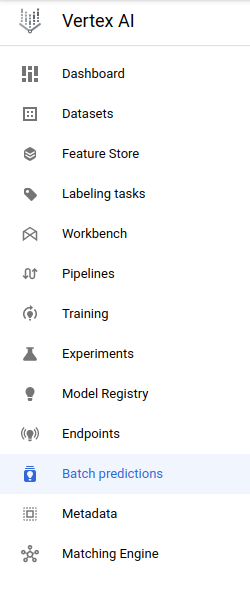

You can check if your batch prediction job is currently in the list of **Batch predictions** list.

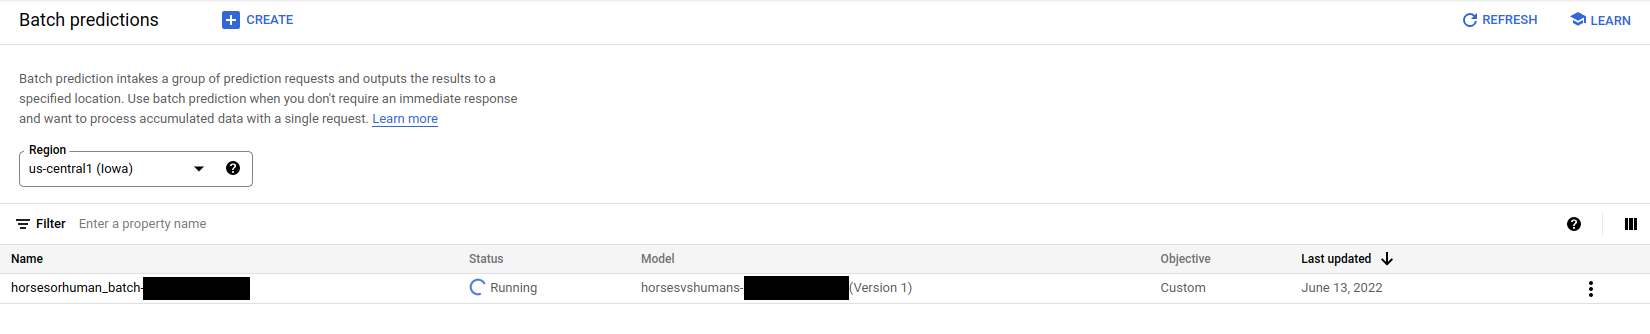

Once the batch prediction is successfull, you should be able to see the status change to `Finished` in the above screenshot.

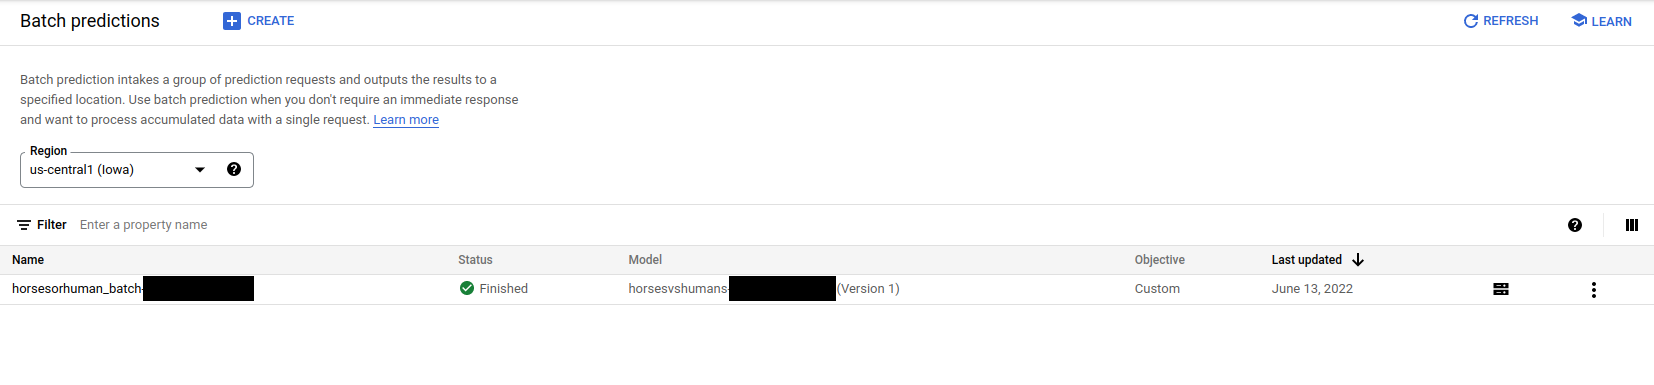

### Retrieve batch prediction results
When the batch prediction is done processing, you can finally view the predictions stored at the Cloud Storage path you set as output. The predictions will be in a JSONL format, which you indicated when you created the batch prediction job. The predictions are located in a subdirectory starting with the name prediction. Within that directory, there is a file named prediction.results-xxxx-of-xxxx.

In [49]:
RESULTS_DIRECTORY = "prediction_results"
RESULTS_DIRECTORY_FULL = RESULTS_DIRECTORY + "/" + DESTINATION_FOLDER

# Create missing directories
os.makedirs(RESULTS_DIRECTORY, exist_ok=True)

# Get the Cloud Storage paths for each result
! gsutil -m cp -r $BATCH_PREDICTION_GCS_DEST_PREFIX $RESULTS_DIRECTORY

# Get most recently modified directory
latest_directory = max(
    [
        os.path.join(RESULTS_DIRECTORY_FULL, d)
        for d in os.listdir(RESULTS_DIRECTORY_FULL)
    ],
    key=os.path.getmtime,
)

# Get downloaded results in directory
results_files = []
for dirpath, subdirs, files in os.walk(latest_directory):
    for file in files:
        if file.startswith("prediction.results"):
            results_files.append(os.path.join(dirpath, file))

# Consolidate all the results into a list
def consolidate_results():          
    # Consolidate all the results into a list
    results = []
    for results_file in results_files:
        # Download each result
        with open(results_file, "r") as file:
            results.extend([json.loads(line) for line in file.readlines()])
    return results
results = consolidate_results()

Copying gs://qwiklabs-gcp-01-dc42083283ed/batch_prediction_results/prediction-horsesvshumans-20250129152132-2025_01_29T07_55_53_470Z/prediction.errors_stats-00000-of-00001...
Copying gs://qwiklabs-gcp-01-dc42083283ed/batch_prediction_results/prediction-horsesvshumans-20250129152132-2025_01_29T07_55_53_470Z/prediction.results-00000-of-00002...
Copying gs://qwiklabs-gcp-01-dc42083283ed/batch_prediction_results/prediction-horsesvshumans-20250129152132-2025_01_29T07_55_53_470Z/prediction.results-00001-of-00002...
- [3/3 files][ 51.5 MiB/ 51.5 MiB] 100% Done                                    
Operation completed over 3 objects/51.5 MiB.                                     


### Rearrange the Batch prediction result

In [50]:
# Rearrange results
def rearrange_results():
    # Empty array to hold the new ordered result
    new_results = [None]*20

    for result in results:
        instance_img = np.array(result["instance"])
        for i in range(len(x_test)):
            # If the result image and x_test image matches,
            # then get the index of the image in x_test.
            # Insert the result into that index
            # in the new_results array
            if (instance_img == x_test[i]).all():
                new_results[i] = result
    return new_results
new_results = rearrange_results()

### Evaluate results

In [51]:
# Evaluate results
def evaluate_results():
    # If the prediction value of result is less than 0.5 then it means model predicted this image to belong to class 0, i.e, horse,
    # else the model predicted the image to belong to class 1, i.e, human.
    y_predicted = [0 if result["prediction"][0] <= 0.5 else 1  for result in new_results]

    correct_ = sum(y_predicted == y_test)
    accuracy = len(y_predicted)
    print(
        f"Correct predictions = {correct_}, Total predictions = {accuracy}, Accuracy = {correct_/accuracy}"
    )
    return y_predicted
y_predicted = evaluate_results()

Correct predictions = 19, Total predictions = 20, Accuracy = 0.95


### Plot the result

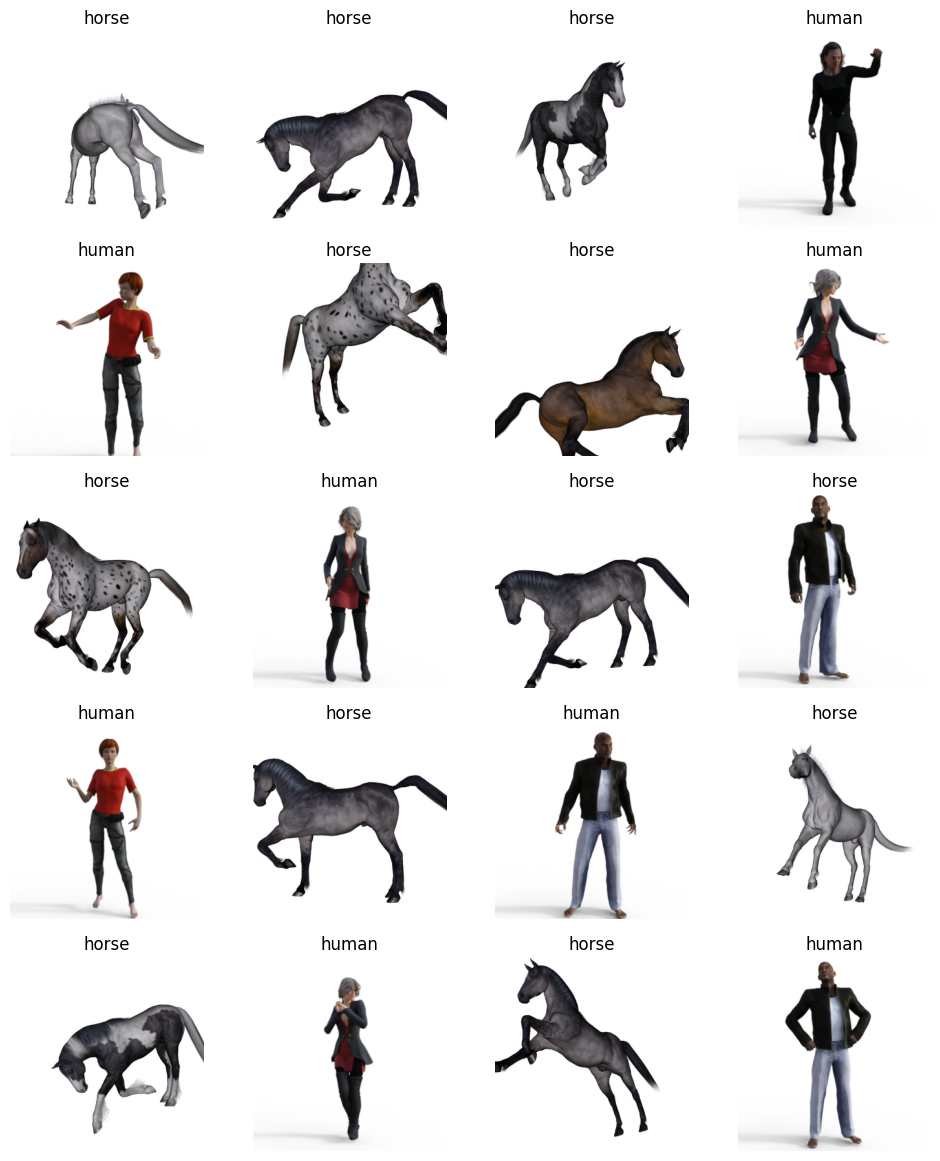

In [52]:
import matplotlib.pyplot as plt

label = {0: 'horse', 1: 'human'}

def display_instance_images(rows=64, cols=4):
  """Display given images and their labels in a grid."""
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  count = 0
  i = 0
  for result in new_results:
      plt.subplot(rows, cols, i + 1)
      plt.axis('off')
      plt.imshow(result['instance'])
      plt.title(label[y_predicted[count]])
      i += 1
      count += 1

display_instance_images()